In this notebook, we explore different ensemble methods, namely Random Forest, XGBoost, LightGBM and CatBoost. We also compare ways of handling class imbalance: \\
1) The combined strategy of asymmetric loss function and optimal classification threshold \\
2) Using undersampled training set \\

We also explore a bayesian optimization based python library called 'hyperOpt' for hyperparamter tuning.

In [1]:
##defining the path to the pre-processed datasets.

from google.colab import drive
drive.mount('/content/gdrive')
data_path = '/content/gdrive/Shareddrives/CIS520 Final Project/dataset/pre_processed/'

Mounted at /content/gdrive


In [2]:
##Importing the required libraries

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
plt.rcParams.update({'font.size': 12})

##Libraries for evaluation metrics and cross validation
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score, ConfusionMatrixDisplay, confusion_matrix

##bayesian optimization baased hyperOpt library
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, space_eval


##Libraries for ensemble methods considered in the study
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
!pip3 install catboost
import catboost

     |████████████████████████████████| 76.3 MB 54 kB/s 


In [3]:
##Reading the Train set 
train = pd.read_csv(data_path + 'Train.csv')
##Defining the X (feature values) and y (target variable) for training
X_train = train.drop(['DIABETE3','_TOTINDA'], axis = 1).values
y_train = train['DIABETE3'].values.astype('int64')

##Reading the Test set 
test = pd.read_csv(data_path + 'Test.csv')
##Defining the X (feature values) and y (test variable) for training
X_test = test.drop(['DIABETE3','_TOTINDA'], axis = 1).values
y_test = test['DIABETE3'].values.astype('int64')

## Helper Functions

First we define some helper functions for tasks like getting confusion matrix, finding optimal threshold, performing k-fold cross validation, obtaining performance metric scores (F1-score, precision and recall) and for getting optimal hyperparamter values using hyperOpt

In [4]:
## Function for evaluating the performance of model based on k-fold validation
def eval_model_cv(model,kfold,X,y):
    """
    Parameters
    ----------
    model : A binary classifier 
        sklearn classifier defined with some hyperparamter values
    kfold : Int
        Number of folds for cross validation
    X : array-like. 
        Input feature values for k-fold validation
    y : array-like. 
        Target variable for k-fold validation

    Output
    ------
    Mean (averaged over k-folds) precision, recall and f1-score values
    """

    ##Performing kfold cross validation with scoring metric as 'F1-score', 'Precision' and 'Recall'
    scores = cross_validate(model, X, y, scoring=['f1','precision','recall'], cv=kfold)
    ##summarize performance for the model on cross validation
    print('The scores for %d-fold cross validation are:' % kfold)
    print('Mean F1-score: %.3f' % np.mean(scores['test_f1']))
    print('Mean Precision: %.3f' % np.mean(scores['test_precision']))
    print('Mean Recall: %.3f' % np.mean(scores['test_recall']))

    return np.mean(scores['test_f1']), np.mean(scores['test_precision']), np.mean(scores['test_recall'])

In [5]:
## Function to find optimal threshold value, i.e. classification threshold for which we have the highest F1-score for a trained model
## code from https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
def opt_threshold(model,classifier,X,y):
    """
    Parameters
    ----------
    model : Trained binary classiification model
    classifier: str
        Name of the classifier
    X : array-like. 
        Containing the feature values
    y : array-like.
        Target variable

    Output
    ------
    thresholds[ix] : Float
        Best classification threshold obtained from the precision-recall curve
    fscore[ix] : Float
        F1-score for {X,y} dataset where class prediction is based on the optimal threshold
    precision[ix] : Float
        Precision for {X,y} dataset where class prediction is based on the optimal threshold
    recall[ix] : Float
        Recall for {X,y} dataset where class prediction is based on the optimal threshold
    """

    ##probabilities for the two classes from the model
    yhat = model.predict_proba(X)
    ##keeping the probabilities for the positive (which is diabetic in our case) outcome only
    yhat = yhat[:, 1]
    ##calculate pr-curve, i.e obtain precision and recall values for different threshold values, using precision_recall_curve() function
    precision, recall, thresholds = precision_recall_curve(y, yhat)
    
    ##Finding indices where both precision and recall are non-zero. This is required to avoid divide by zero while calculating f-score
    non_zero_pr_indices = np.where(np.logical_not(np.equal(precision,recall)))[0]
    ##Calcualte f1 score using precision and recall values 
    fscore = np.zeros(precision.shape)
    fscore[non_zero_pr_indices] = (2 * precision[non_zero_pr_indices] * recall[non_zero_pr_indices])/ (precision[non_zero_pr_indices] + recall[non_zero_pr_indices])
    ##locate the index of the largest f score
    ix = np.argmax(fscore)
    print('\n Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], fscore[ix], precision[ix], recall[ix])) 

    ##plot the precision-recall curve for the model along with the point for optimal threshold
    no_skill = len(y[y==1]) / len(y)
    plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
    plt.plot(recall, precision, marker='.', label=classifier)
    plt.plot(recall[ix], precision[ix], marker='o', color='black', label='Best Classification \n Threshold = '+str(round(thresholds[ix],3)))
    ##axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    #plt.savefig(classifier+"_PRCurve.png",bbox_inches = 'tight')
    #files.download(classifier+"_PRCurve.png")
    plt.show()

    ##Predict the classes based on the optimal threshold, i.e. if probability >= optimal threshold, then class is 1 (diabetic)
    y_pred = np.zeros(yhat.shape)
    y_pred[np.where(yhat>=thresholds[ix])] = 1
    ##Compute the Confusion Matrix 
    print('\n Confusion matrix for training data:')
    disp = ConfusionMatrixDisplay(confusion_matrix(y,y_pred,labels=[1,0]), display_labels=[1,0])
    disp.plot()
    #plt.savefig(classifier+"_ConfMat.png",bbox_inches = 'tight')
    #files.download(classifier+"_ConfMat.png")
    plt.show()
    ##Compute the f1-score for the confusion matrix
    print('F1-score for the confusion matrix: %f' % f1_score(y,y_pred))

    return thresholds[ix], fscore[ix], precision[ix], recall[ix]

In [6]:
## Function for computing the evaluation metrics for a trained model on the test set
def eval_model_test(model,classifier,X,y,threshold=0.5):
    """
    Parameters
    ----------
    model : Trained binary classiification model 
        sklearn classifier defined with some hyperparamter values
    classifier: str
        Name of the classifier
    X : array-like. 
        Feature values for the test set
    y : array-like. 
        Target variable values for the test set
    threshold: Float
        Classification threshold to be used for class prediction. If no value passed, then default threshold of 0.5 is assumed
    """

    ##probabilities for the two classes from the model
    yhat = model.predict_proba(X)
    ##keeping the probabilities for the positive (which is diabetic in our case) outcome only
    yhat = yhat[:, 1]

    ##Predict the classes based on the threshold, i.e. if probability >= threshold, then class is 1 (diabetic)
    y_pred = np.zeros(yhat.shape)
    y_pred[np.where(yhat>=threshold)] = 1

    print('Scores on the test set for %s:' % classifier)
    ##Compute precision for the test set
    print('Precision: %.3f' % precision_score(y_test,y_pred))
    ##Compute recall for the test set
    print('Recall: %.3f' % recall_score(y_test,y_pred))
    ##Compute f1-score for the test set
    print('F1-score: %.3f' % f1_score(y_test,y_pred))

In [7]:
## Function to making confusion matrix for a trained model, and given X and y
def conf_mat(model,X,y):
    """
    Parameters
    ----------
    model : Trained binary classiification model
    X : array-like. 
        Containing the feature values
    y : array-like.
        Target variable
    """
    
    ##Compute the Confusion Matrix using confusion_matrix() function and then using ConfusionMatrixDisplay() for displaying the matrix 
    disp = ConfusionMatrixDisplay(confusion_matrix(y,model.predict(X),labels=[1,0]), display_labels=[1,0])
    disp.plot()
    plt.show()

    ##Compute the f1-score for the confusion matrix
    print('F1-score for the confusion matrix: %f' % f1_score(y,model.predict(X)))

In [8]:
## Function for plotting precision-recall curve for a trained model, and given X and y
def pr_curve(model,classifier,X,y):
    """
    Parameters
    ----------
    model : Trained binary classiification model
    classifier: str
        Name of the classifier
    X : array-like. 
        Containing the feature values
    y : array-like.
        Target variable
    """

    ##probabilities for the two classes from the model
    yhat = model.predict_proba(X)
    ##keeping the probabilities for the positive (which is diabetic in our case) outcome only
    yhat = yhat[:, 1]
    ##calculate pr-curve, i.e obtain precision and recall values for different threshold values, using precision_recall_curve() function
    precision, recall, thresholds = precision_recall_curve(y, yhat)
    
    ##plotting the pr-curve for the model
    no_skill = len(y[y==1]) / len(y)
    plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
    plt.plot(recall, precision, marker='.', label=classifier)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()

Using Bayesian optimization based hyperopt python library for finding the optimal hyperparameter set.

In [9]:
##Code for using hyperopt for hysperparameter search to optimize F1 score is taken from
##https://www.kaggle.com/rendyk/bayesian-optimization-bayes-opt-or-fmin#hyperopt
##https://districtdatalabs.silvrback.com/parameter-tuning-with-hyperopt

##Function to compute the optimal hyperparamter values using hyperOpt
def opt_hyperparameter(parameter_space,func_model,max_iterations):
    """
    Parameters
    ----------
    parameter_space : dict
        parameter space to be explored for optimizing F1 score where each key refers to a hyperparamter 
        and that key's corresponding value defines the space to be explored for that hyperparamter 
    func_model : value-returning function 
        To be minimized by hyperopt.fmin(). In our case, since we want to maximize f1-score, func_model returns 
        negative of F1-score where F1-score is obatined as mean f1-score from 5-fold cross validation
    max_iterations : Int
        maximum number of evaluations the fmin function will perform

    Output
    ------
    best: dict
        Optimal hyperparameter values obtained from fmin
    trials: object of type hyperopt.base.Trials
        Contains various outputs/characteristics after each evaluation, can be used to analysis 
        the optimization history
    """
 
    trials = Trials()
    best = fmin(fn = func_model, space = parameter_space, algo=tpe.suggest, max_evals=max_iterations, trials=trials)

    return best, trials

##================================
##Function for plotting optimization history (F1-score vs iteration number)
##Taken from https://www.kaggle.com/fanvacoolt/tutorial-on-hyperopt
def optimization_history(trials):
    """
    Parameters
    ----------
    trials: object of type hyperopt.base.Trials
        Contains various outputs/characteristics after each evaluation, can be used to analysis 
        the optimization history
    """

    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(trials) + 1), [-x['result']['loss'] for x in trials], 
            color='red', marker='.', linewidth=0)
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('F1-score', fontsize=12)
    plt.title('Optimization history', fontsize=14)
    plt.grid(True)

## Training and Testing Ensemble Methods

Random Forest and Gradient Boosting (XGBoost, LightGBM and CatBoost) are implemented in the following sections. \\
The analysis pipeline followed is: \\
1) Try the model with default parameters \\
2) Add class weights for asymmetry between classes and see how performance changes \\
3) Find optimal hyperparameters based on 5-fold cross validation using HyperOpt \\
4) Calculate optimal threshold value using precision-recall curve for the model trained on optimized hyperparameter values

### Random Forest Classifier

To start with, we use the default paramter values (except max_depth = 4) of RandomForestClasifier. 

Performance of vanilla random forest

The scores for 5-fold cross validation are:
Mean F1-score: 0.007
Mean Precision: 0.760
Mean Recall: 0.003


 Confusion matrix for whole training data:


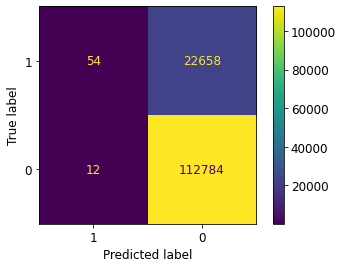

F1-score for the confusion matrix: 0.004741


In [10]:
##define model
clf_rf = RandomForestClassifier(max_depth=4,random_state=1)

print("Performance of vanilla random forest")
print()

##evaluate model using kfold cross validation
f1, precision, recall = eval_model_cv(clf_rf, 5, X_train, y_train)

##Fitting the model on training set
clf_rf.fit(X_train,y_train)
##Confusion Matrix for whole training set
print()
print('\n Confusion matrix for whole training data:')
conf_mat(clf_rf,X_train,y_train)

Next, for handling class imbalance, we try the class_weight hyperparameter of RandomForestClassifier. Two modes for class_weights examined by us are as follows:

'balanced' mode: the weights associated with each class are  automatically adjusted to $\cfrac{\text{(Total number of samples)}}{\text{((number of classes) * np.bincount(y[class]))}}$. i.e. weights are taken as inversely proportional to class frequency in the input data.

'balanced_subsample' mode: same as 'balanced' except that the weights are now adjusted for each tree grown individually based on the training subset (bagging + bootstrap) used for that tree.

Performance of random forest with class_weight='balanced'

The scores for 5-fold cross validation are:
Mean F1-score: 0.444
Mean Precision: 0.316
Mean Recall: 0.749


 Confusion matrix for whole training data:


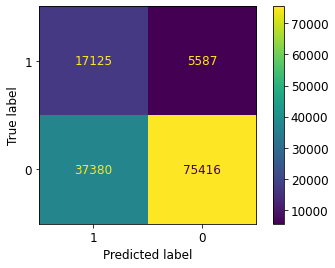

F1-score for the confusion matrix: 0.443555


In [11]:
##define model
clf_rf = RandomForestClassifier(max_depth=4,class_weight='balanced',random_state=1)

print("Performance of random forest with class_weight='balanced'")
print()

##evaluate model using kfold cross validation
f1, precision, recall = eval_model_cv(clf_rf, 5, X_train, y_train)

##Fitting the model on training set
clf_rf.fit(X_train,y_train)
##Confusion Matrix for whole training set
print()
print('\n Confusion matrix for whole training data:')
conf_mat(clf_rf,X_train,y_train)

Performance of random forest with class_weight='balanced_subsample'

The scores for 5-fold cross validation are:
Mean F1-score: 0.444
Mean Precision: 0.315
Mean Recall: 0.749


 Confusion matrix for whole training data:


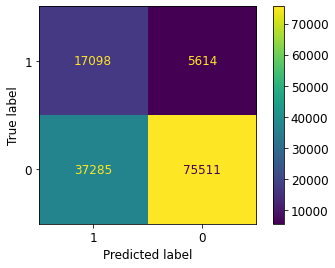

F1-score for the confusion matrix: 0.443557


In [12]:
##define model
clf_rf = RandomForestClassifier(max_depth=4,class_weight='balanced_subsample',random_state=1)

print("Performance of random forest with class_weight='balanced_subsample'")
print()

##evaluate model using kfold cross validation
f1, precision, recall = eval_model_cv(clf_rf, 5, X_train, y_train)

##Fitting the model on training set
clf_rf.fit(X_train,y_train)
##Confusion Matrix for whole training set
print()
print('\n Confusion matrix for whole training data:')
conf_mat(clf_rf,X_train,y_train)

We can see that adding asymmetry to classes via class_weight = 'balanced_subsample' and 'balanced' gives much better performance than taking classes to be symmetric.

We can further tune the hyperparameters. For this, we will be using bayesian optimization based hyperopt python library. \\
**Note:** \\
**1) Run time for the following hyperparamter search is ~40 min. Consider using the optimal hyperparameter pre-defined in the next cell that has been found after running this hyperparmameter search.** \\
**2) Due to randomization in the hyperOpt based search, you might get different values for the hyperparamter if you run the hyperparameter search in the next cell. But the optimal mean F1-score (average over k-fold CV) from the search would still be around 0.459 for Random Forest.**

{'class_weight': 'balanced_subsample', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_split': 3, 'n_estimators': 350}
New best F1-score: 0.440169
{'class_weight': 'balanced_subsample', 'max_depth': 2, 'max_features': 'log2', 'min_samples_split': 5, 'n_estimators': 431}
{'class_weight': 'balanced_subsample', 'max_depth': 3, 'max_features': 'log2', 'min_samples_split': 3, 'n_estimators': 149}
New best F1-score: 0.442539
{'class_weight': 'balanced', 'max_depth': 2, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 113}
New best F1-score: 0.442745
{'class_weight': 'balanced', 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_split': 7, 'n_estimators': 183}
New best F1-score: 0.455872
{'class_weight': 'balanced_subsample', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 478}
{'class_weight': 'balanced_subsample', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_split': 3, 'n_estimators': 200}
{'class_weight': 'balanced_subsample', '

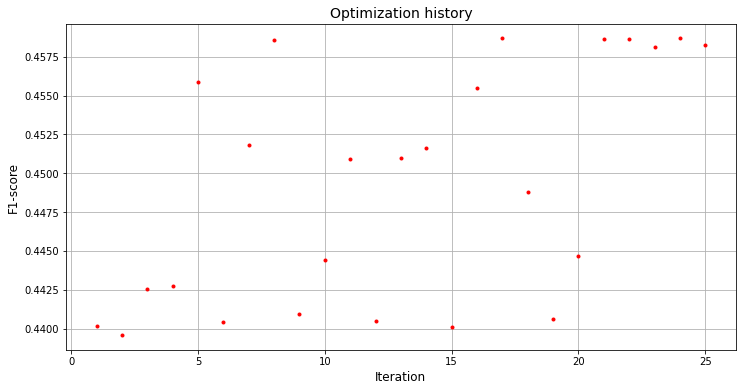

In [ ]:
##Code for using hyperopt for hysperparameter search to optiiza F1 score taken from
##https://www.kaggle.com/rendyk/bayesian-optimization-bayes-opt-or-fmin#hyperopt
##https://districtdatalabs.silvrback.com/parameter-tuning-with-hyperopt

##Define the hyperparamter space
rf_param_space = {'max_depth': hp.choice('max_depth', range(2,9)),
 'max_features': hp.choice('max_features', ['sqrt','log2']),
 'min_samples_split': hp.choice('min_samples_split',range(2,8)),
 'n_estimators': hp.choice('n_estimators', range(100,500)),
 'class_weight': hp.choice('class_weight', ['balanced','balanced_subsample'])}

best = 0  
##The function to be optimized by hyperopt.fmin(), i.e. output of this function is mean f1-score (averaged over k-fold CV) 
##which is being optimized by hyprOpt.fmin().
def rfc_func(params):
    global best
    print(params)

    ##Define the random forest classifier
    clf = RandomForestClassifier(random_state=1,**params)
    ##Compute the mean f1 score for kfold cross validation
    score = cross_val_score(clf, X_train, y_train, scoring='f1', cv=5).mean()
    ##For keeping track of optimal f1-score, print the score everytime a better value is found
    if score > best:
        best = score
        print ('New best F1-score: %f' % best)

    ##returning -ve of score because hyperopt.fmin() minimizes a function. So in our case, we are minimizing -ve of f1-score.
    return {'loss': -score, 'status': STATUS_OK}  

##Start the timer for hyperparamter optimization
start = time.time()
##Max number of evaluations for hyperopt.fmin()
max_iterations = 25
##Find the optimal hyperparamter set. Also storing the optimization history.
rf_param_space_indices, rf_trials = opt_hyperparameter(rf_param_space,rfc_func,max_iterations)
##Obtain the hyperparamter values in the hyperparamter space defined by rf_param_space_indices
rf_best_hp = space_eval(rf_param_space,rf_param_space_indices)

print('It takes %s minutes' % ((time.time() - start)/60))
print('---------------Optimal Hyperparamter Set-------------------')
print(rf_best_hp)
print('---------------Optimization History-------------------')
optimization_history(rf_trials)

The cell below has the optimal hyperparameters found for random forest after running the search in previous cell. **Please uncomment if you want to use this hyperparameter set instead of running the hyperOpt based search.** \\
**Note: Due to randomization in the hyperOpt based search, you might get different values for the optimal hyperparamter if you ran the hyperparameter search in previous cell. But the optimal mean F1-score (average over k-fold CV) from the search would still be around 0.459 for random forest.** 

In [13]:
#rf_best_hp={'class_weight': 'balanced', 'max_depth': 8, 'max_features': 'log2', 'min_samples_split': 6, 'n_estimators': 207}

Assessing the performance of the random forest with optimal hyperparamters based on 5-fold CV and on the whole training set. \\
We find that the performance improves with hyperparameter tuning.

Performance of random forest with optimal hyperparamters

The scores for 5-fold cross validation are:
Mean F1-score: 0.459
Mean Precision: 0.329
Mean Recall: 0.758


 Confusion matrix for training data:


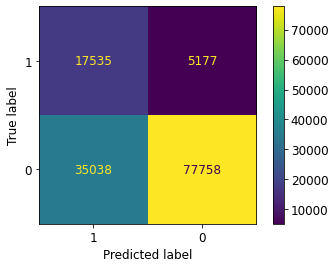

F1-score for the confusion matrix: 0.465830


In [14]:
##define model with optimal hyperparameters
rfc_best = RandomForestClassifier(random_state=1, **rf_best_hp)

print("Performance of random forest with optimal hyperparamters")
print()

##evaluate model using kfold cross validation
f1, precision, recall = eval_model_cv(rfc_best, 5, X_train, y_train)

##Confusion Matrix for training data
rfc_best.fit(X_train,y_train)
##Confusion Matrix for whole training set
print()
print('\n Confusion matrix for training data:')
conf_mat(rfc_best,X_train,y_train)

Next we find the best classification threshold for the trained random forest classifier (with optimal hyperparamters), i.e. threshold that gives maximum f1-score on the precision-recall curve.


 Best Threshold=0.571942, F-Score=0.484, Precision=0.390, Recall=0.638


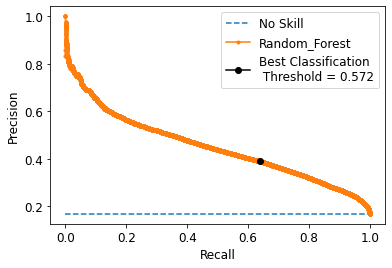


 Confusion matrix for training data:


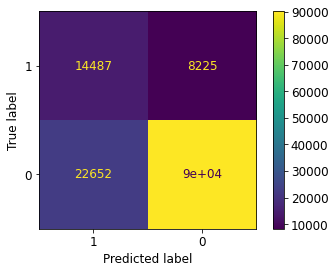

F1-score for the confusion matrix: 0.484102


In [15]:
##Finding the Optimal threshold value
threshold_rf, best_f1_rf, best_precison_rf, best_recall_rf = opt_threshold(rfc_best,'Random_Forest', X_train, y_train)

Finally, we check the performance for the trained random forest classifier (with optimal hyperparamters) on the test set with best classification threshold (obtained in previous cell) used for class prediction.

In [16]:
##summarize performance of random forest on test set
eval_model_test(rfc_best,'Random Forest',X_test,y_test,threshold_rf)

Scores on the test set for Random Forest:
Precision: 0.381
Recall: 0.617
F1-score: 0.471


### XGBoost Classifier

The learning objective used is **'binary:logistic'** which has the same log-loss (cost) function as logistic regression for binary classification.

To start with, we use the default paramter values of XGBClassifier.

Performance of vanilla XGBoost

The scores for 5-fold cross validation are:
Mean F1-score: 0.245
Mean Precision: 0.586
Mean Recall: 0.155


 Confusion matrix for whole training data:


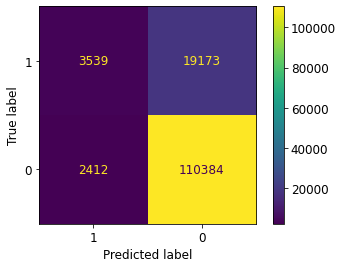

F1-score for the confusion matrix: 0.246939


In [17]:
##define model
clf_xgb = XGBClassifier(objective='binary:logistic', random_state=1)

print("Performance of vanilla XGBoost")
print()

##evaluate model using kfold cross validation
f1, precision, recall = eval_model_cv(clf_xgb, 5, X_train, y_train)

##Fitting the model on training set
clf_xgb.fit(X_train,y_train)
##Confusion Matrix for whole training set
print()
print('\n Confusion matrix for whole training data:')
conf_mat(clf_xgb,X_train,y_train)

Next, for handling class imbalance, asymmetry in the cost function is introduced through the hyperparameter $\textit{scale_pos_weight}$ which can be seen as the weight for positive class (i.e. diabetic in our case). \\

Here, we have taken $\textit{scale_pos_weight}= 6$ based on the heuristic given in [XGBoost documentation](https://xgboost.readthedocs.io/en/stable/parameter.html) that suggests that a good value to try is the ratio of number of negative class to the positive class which in our case refers to $\cfrac{count(\text{non-diabetic})}{count(diabetic)} \approx 6\$.

Performance of XGBoost with asymmetric loss function

The scores for 5-fold cross validation are:
Mean F1-score: 0.449
Mean Precision: 0.311
Mean Recall: 0.813


 Confusion matrix for whole training data:


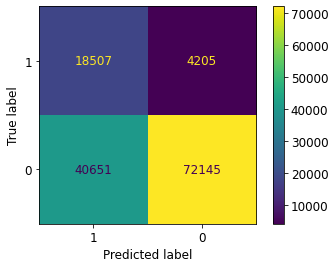

F1-score for the confusion matrix: 0.452107


In [37]:
##define model
clf_xgb = XGBClassifier(objective='binary:logistic', scale_pos_weight = 6, random_state=1)

print("Performance of XGBoost with asymmetric loss function")
print()

##evaluate model using kfold cross validation
f1, precision, recall = eval_model_cv(clf_xgb, 5, X_train, y_train)

##Fitting the model on training set
clf_xgb.fit(X_train,y_train)
##Confusion Matrix for whole training set
print()
print('\n Confusion matrix for whole training data:')
conf_mat(clf_xgb,X_train,y_train)

We can see that adding asymmetry to loss function via scale_pos_weight gives much better performance than taking classes to be symmetric in loss function.

We can further tune the hyperparameters. For this, we will be using bayesian optimization based hyperopt python library. \\
**Note:** \\
**1) Run time for the following hyperparamter search is ~25 min. Consider using the optimal hyperparameter pre-defined in the next cell that has been found after running this hyperparmameter search.** \\
**2) Due to randomization in the hyperOpt based search, you might get different values for the hyperparamter if you run the hyperparameter search in the next cell. But the optimal mean F1-score (average over k-fold CV) from the search would still be around 0.476 for XGBoost.**

{'colsample_bytree': 0.797723643638443, 'gamma': 0.23733609593864607, 'learning_rate': 0.47147127499955926, 'max_depth': 5, 'n_estimators': 343, 'reg_lambda': 3.988394627252892, 'scale_pos_weight': 5.474125516301451, 'subsample': 0.7779828440427132}
new best:
0.4425277045574414
{'colsample_bytree': 0.5368910165619626, 'gamma': 0.04029808944528672, 'learning_rate': 0.2177837873821929, 'max_depth': 2, 'n_estimators': 123, 'reg_lambda': 2.3610012375044462, 'scale_pos_weight': 4.439213569596815, 'subsample': 0.691528567176815}
new best:
0.4699137020189741
{'colsample_bytree': 0.8375777397584889, 'gamma': 0.14467857567760842, 'learning_rate': 0.3801667697678734, 'max_depth': 4, 'n_estimators': 387, 'reg_lambda': 1.5254511128526105, 'scale_pos_weight': 4.066443558052949, 'subsample': 0.6385871081980099}
{'colsample_bytree': 0.7283523078600569, 'gamma': 0.1261182330554961, 'learning_rate': 0.42601214167106943, 'max_depth': 3, 'n_estimators': 123, 'reg_lambda': 1.785165444561427, 'scale_pos_we

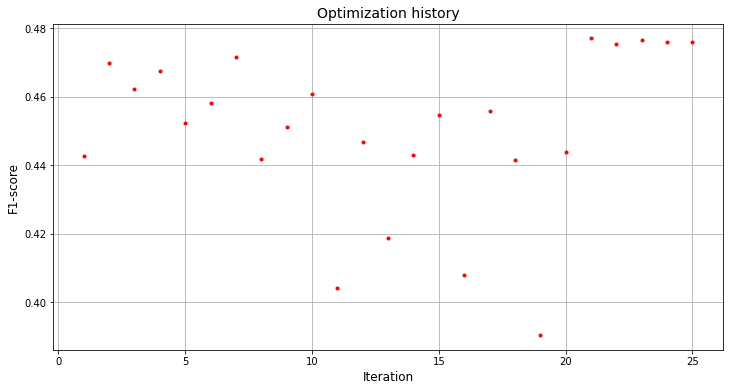

In [ ]:
##Code for using hyperopt for hysperparameter search to optiiza F1 score taken from
##https://www.kaggle.com/rendyk/bayesian-optimization-bayes-opt-or-fmin#hyperopt
##https://districtdatalabs.silvrback.com/parameter-tuning-with-hyperopt

##Define the hyperparamterparamter space
xgbc_param_space = {'max_depth': hp.choice('max_depth', range(2,9)),
 'learning_rate': hp.uniform('learning_rate',0.05,0.5),
 'subsample': hp.uniform('subsample',0.5,1.0),
 'n_estimators': hp.choice('n_estimators', range(100,500)),
 'scale_pos_weight': hp.uniform('scale_pos_weight',3,6),
 'reg_lambda': hp.uniform('reg_lambda',1,4),
 'gamma': hp.uniform('gamma',0,0.3),
 'colsample_bytree': hp.uniform('colsample_bytree',0.5,1.0)}

best = 0
##The function to be optimized by hyperopt.fmin(), i.e. output of this function is mean f1-score (averaged over k-fold CV) 
##which is being optimized by hyprOpt.fmin().
def xgbc_func(params):
    global best
    print(params)
    
    ##Define XGBoost classifier
    clf = XGBClassifier(tree_method='hist',objective='binary:logistic',random_state=1,**params)
    ##Compute the mean f1 score for kfold cross validation
    score = cross_val_score(clf, X_train, y_train, scoring='f1', cv=5).mean()
    ##For keeping track of optimal f1-score, print the score everytime a better value is found
    if score > best:
        best = score
        print ('new best:', best)

    ##returning -ve of score because hyperopt.fmin() minimizes a function. So in our we are minimizing -ve of f1-score.
    return {'loss': -score, 'status': STATUS_OK}

##Start the timer for hyperparamter optimization
start = time.time()
##Max number of evaluations for hyperopt.fmin()
max_iterations = 25
##Find the optimal hyperparamter set. Also storing the optimization history
xgbc_param_space_indices, xgbc_trials = opt_hyperparameter(xgbc_param_space,xgbc_func,max_iterations)
##Obtain the hyperparamter values in the hyperparamter space defined by xgbc_param_space_indices
xgbc_best_hp = space_eval(xgbc_param_space,xgbc_param_space_indices)

print('It takes %s minutes' % ((time.time() - start)/60))
print('---------------Optimal Hyperparamter Set-------------------')
print(xgbc_best_hp)
print('---------------Optimization History-------------------')
optimization_history(xgbc_trials)

The cell below has the optimal hyperparameters found for XGBoost classifier after running the search in previous cell. **Please uncomment if you want to use this hyperparameter set instead of running the hyperOpt based search.** \\
**Note: Due to randomization in the hyperOpt based search, you might get different values for the optimal hyperparamter if you ran the hyperparameter search in previous cell. But the optimal mean F1-score (average over k-fold CV) from the search would still be around 0.476 for XGBoost classifier.** 

In [19]:
#xgbc_best_hp = {'colsample_bytree': 0.5002434272961336, 'gamma': 0.200243397268651, 'learning_rate': 0.0664934487358943, 'max_depth': 2, 'n_estimators': 200, 'reg_lambda': 2.9474389500282516, 'scale_pos_weight': 3.1602129545143036, 'subsample': 0.5929914167765773}

Assessing the performance of the xgboost classifier with optimal hyperparamters based on 5-fold CV and on the whole training set. \\
We find that the performance improves with hyperparameter tuning.

Performance of XGBoost classifier with optimal hyperparamters

The scores for 5-fold cross validation are:
Mean F1-score: 0.476
Mean Precision: 0.392
Mean Recall: 0.606


 Confusion matrix for training data:


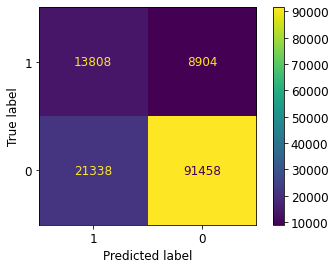

F1-score for the confusion matrix: 0.477307


In [20]:
##define model with optimal hyperparameters
xgbc_best = XGBClassifier(objective='binary:logistic',random_state=1,**xgbc_best_hp)

print("Performance of XGBoost classifier with optimal hyperparamters")
print()

##evaluate model using kfold cross validation
f1, precision, recall = eval_model_cv(xgbc_best, 5, X_train, y_train)

##Fitting the model on training set
xgbc_best.fit(X_train,y_train)
##Confusion Matrix for whole training set
print()
print('\n Confusion matrix for training data:')
conf_mat(xgbc_best,X_train,y_train)

Next we find the best classification threshold for the trained XGBoost classifier (with optimal hyperparamters), i.e. threshold that gives maximum f1-score on the precision-recall curve.


 Best Threshold=0.481037, F-Score=0.479, Precision=0.383, Recall=0.638


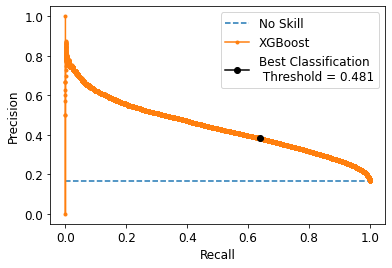


 Confusion matrix for training data:


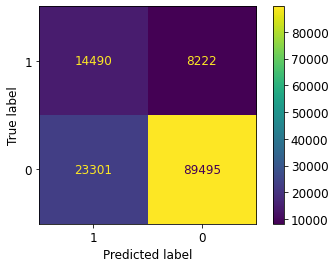

F1-score for the confusion matrix: 0.478985


In [21]:
##Finding the Optimal threshold value
threshold_xgb, best_f1_xgb, best_precison_xgb, best_recall_xgb = opt_threshold(xgbc_best,'XGBoost', X_train, y_train)

Finally, we check the performance for the trained XGBoost classifier (with optimal hyperparamters) on the test set with best classification threshold (obtained in previous cell) used for class prediction.

In [22]:
##summarize performance of XGBoost on test set
eval_model_test(xgbc_best,'XGBoost',X_test,y_test,threshold_xgb)

Scores on the test set for XGBoost:
Precision: 0.384
Recall: 0.629
F1-score: 0.477


### LightGBM Classifier

LightGBM primarily differs from XGBoost in the in the way it constructs trees. In XGBoost, the trees grow row-by-row (level-wise), while LigthGBM grows trees leaf-wise. The approaches are summarized in the figure below

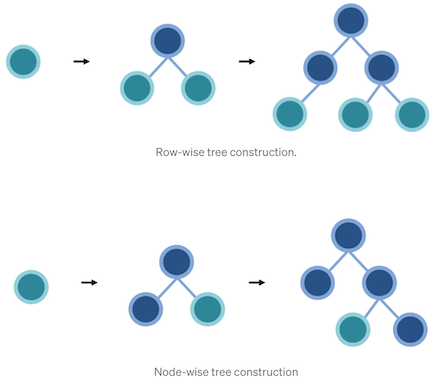

[Figure taken from](https://towardsdatascience.com/xgboost-lightgbm-and-other-kaggle-competition-favorites-6212e8b0e835)

Note that due to the leaf-wise strategy employed by LightGBM to grow trees, to avoid overfitting $num\_leaves$ (maximum tree leaves) has to be less than $2^{max\_depth}$ ([LightGBM Documentation](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html#tune-parameters-for-the-leaf-wise-best-first-tree)). We took $num\_leaves = 0.6\left(2^{max\_depth}\right)$ for all LightGBM models tried.

The learning objective used is **'binary'** which has the same log-loss (cost) function as logistic regression for binary classification.

To start with, we use the default paramter values (except max_depth = 3 and num_leaves = 5) of LGBMClassifier.

Performance of vanilla LightGBM

The scores for 5-fold cross validation are:
Mean F1-score: 0.253
Mean Precision: 0.579
Mean Recall: 0.162


 Confusion matrix for whole training data:


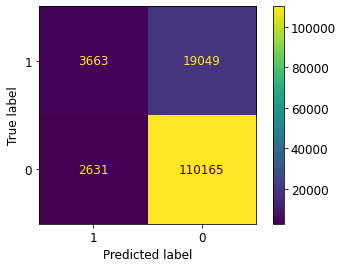

F1-score for the confusion matrix: 0.252568


In [23]:
##define model
clf_lgbm = lgb.LGBMClassifier(objective='binary',max_depth=3,num_leaves=5)

print("Performance of vanilla LightGBM")
print()

##evaluate model using kfold cross validation
f1, precision, recall = eval_model_cv(clf_lgbm, 5, X_train, y_train)

##Fitting the model on training set
clf_lgbm.fit(X_train,y_train)
##Confusion Matrix for whole training set
print()
print('\n Confusion matrix for whole training data:')
conf_mat(clf_lgbm,X_train,y_train)

Next, for handling class imbalance, asymmetry in the cost function is introduced through the hyperparameter $\textit{scale_pos_weight}$ which can be seen as the weight for positive class (i.e. diabetic in our case). \\

Here, we have taken $\textit{scale_pos_weight}= 6$ based on the heuristic used for XGBoost classifier before.

Performance of LightGBM with asymmetric loss function

The scores for 5-fold cross validation are:
Mean F1-score: 0.447
Mean Precision: 0.308
Mean Recall: 0.817


 Confusion matrix for whole training data:


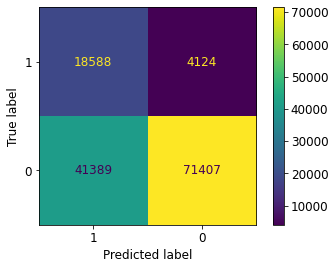

F1-score for the confusion matrix: 0.449588


In [24]:
##define model
clf_lgbm = lgb.LGBMClassifier(objective='binary',max_depth=3,num_leaves=5,scale_pos_weight=6)

print("Performance of LightGBM with asymmetric loss function")
print()

##evaluate model using kfold cross validation
f1, precision, recall = eval_model_cv(clf_lgbm, 5, X_train, y_train)

##Fitting the model on training set
clf_lgbm.fit(X_train,y_train)
##Confusion Matrix for whole training set
print()
print('\n Confusion matrix for whole training data:')
conf_mat(clf_lgbm,X_train,y_train)

We can see that adding asymmetry to loss function via scale_pos_weight gives much better performance than taking classes to be symmetric in loss function.

We can further tune the hyperparameters. For this, we will be using bayesian optimization based hyperopt python library. \\
**Note:** \\
**1) Run time for the following hyperparamter search is ~8-10 min. Consider using the optimal hyperparameter pre-defined in the next cell that has been found after running this hyperparmameter search.** \\
**2) Due to randomization in the hyperOpt based search, you might get different values for the hyperparamter if you run the hyperparameter search in the next cell. But the optimal mean F1-score (average over k-fold CV) from the search would still be around 0.476 for LightGBM.**

{'colsample_bytree': 0.6535598127209323, 'learning_rate': 0.10868952042846891, 'max_depth': 3, 'min_split_gain': 0.02705719380021554, 'n_estimators': 193, 'reg_lambda': 1.1400412279242005, 'scale_pos_weight': 5.95280784981661, 'subsample': 0.515681238961717}
new best:
0.45053080719196903
{'colsample_bytree': 0.9191092866070154, 'learning_rate': 0.29890719172966235, 'max_depth': 4, 'min_split_gain': 0.045355148852214484, 'n_estimators': 102, 'reg_lambda': 3.8040663384647497, 'scale_pos_weight': 4.170715583478268, 'subsample': 0.7029649083746854}
new best:
0.47023629521585314
{'colsample_bytree': 0.835073800808818, 'learning_rate': 0.42017765819440644, 'max_depth': 6, 'min_split_gain': 0.10767078620280508, 'n_estimators': 339, 'reg_lambda': 3.7777545908495993, 'scale_pos_weight': 5.769934951100163, 'subsample': 0.8294532790700363}
{'colsample_bytree': 0.7966970555854764, 'learning_rate': 0.346267367432714, 'max_depth': 6, 'min_split_gain': 0.26369160359773647, 'n_estimators': 423, 'reg_l

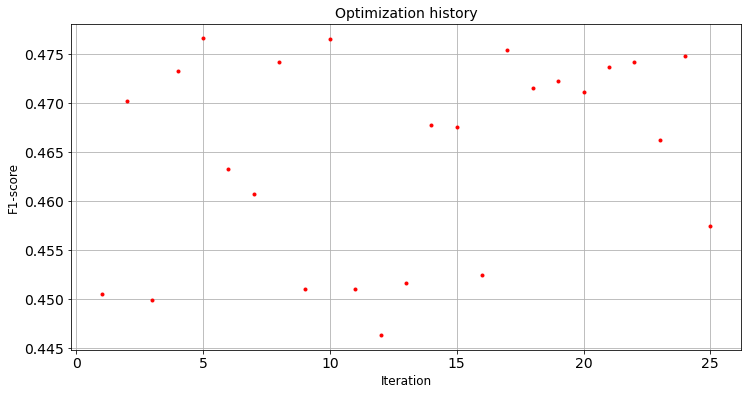

In [ ]:
##Code for using hyperopt for hysperparameter search to optimize F1 score taken from
##https://www.kaggle.com/rendyk/bayesian-optimization-bayes-opt-or-fmin#hyperopt
##https://districtdatalabs.silvrback.com/parameter-tuning-with-hyperopt

##Define the hyperparamterparamter space
lgbmc_param_space = {'max_depth': hp.choice('max_depth', range(3,9)),
 'learning_rate': hp.uniform('learning_rate',0.05,0.5),
 'subsample': hp.uniform('subsample',0.5,1.0),
 'n_estimators': hp.choice('n_estimators', range(100,500)),
 'scale_pos_weight': hp.uniform('scale_pos_weight',3,6),
 'min_split_gain': hp.uniform('min_split_gain',0,0.3),
 'colsample_bytree': hp.uniform('colsample_bytree',0.5,1.0),
 'reg_lambda': hp.uniform('reg_lambda',1,4)}

best = 0
##The function to be optimized by hyperopt.fmin(), i.e. output of this function is mean f1-score (averaged over k-fold CV) 
##which is being optimized by hyprOpt.fmin().
def lgbmc_func(params):
    global best
    print(params)

    ##Define LightGBM classifier
    clf = lgb.LGBMClassifier(objective='binary',random_state=1,num_leaves = round(np.power(2,params['max_depth'])*0.6),**params)
    ##Compute the mean f1 score for kfold cross validation
    score = cross_val_score(clf, X_train, y_train, scoring='f1', cv=5).mean()
    ##For keeping track of optimal f1-score, print the score everytime a better value is found
    if score > best:
        best = score
        print ('new best:', best)

    ##returning -ve of score because hyperopt.fmin() minimizes a function. So in our we are minimizing -ve of f1-score.
    return {'loss': -score, 'status': STATUS_OK}

##Start the timer for hyperparamter optimization
start = time.time()
##Max number of evaluations for hyperopt.fmin()
max_iterations = 25
##Find the optimal hyperparamter set. Also storing the optimization history.
lgbmc_param_space_indices, lgbmc_trials = opt_hyperparameter(lgbmc_param_space,lgbmc_func,max_iterations)
##Obtain the hyperparamter values in the hyperparamter space defined by lgbmc_param_space_indices
lgbmc_best_hp = space_eval(lgbmc_param_space,lgbmc_param_space_indices)

print('It takes %s minutes' % ((time.time() - start)/60))
print('---------------Optimal Hyperparamter Set-------------------')
print(lgbmc_best_hp)
print('---------------Optimization History-------------------')
optimization_history(lgbmc_trials)

The cell below has the optimal hyperparameters found for LightGBM classifier after running the search in previous cell. **Please uncomment if you want to use this hyperparameter set instead of running the hyperOpt based search.** \\
**Note: Due to randomization in the hyperOpt based search, you might get different values for the optimal hyperparamter if you ran the hyperparameter search in previous cell. But the optimal mean F1-score (average over k-fold CV) from the search would still be around 0.476 for LightGBM classifier.** 

In [25]:
#lgbmc_best_hp={'colsample_bytree': 0.8002875270990324, 'learning_rate': 0.0599624618392627, 'max_depth': 3, 'min_split_gain': 0.24613935939490317, 'n_estimators': 491, 'reg_lambda': 3.202973397807609, 'scale_pos_weight': 3.8529686221558865, 'subsample': 0.5283968376023029}

Assessing the performance of the lightGBM classifier with optimal hyperparamters based on 5-fold CV and on the whole training set. \\
We find that the performance improves with hyperparameter tuning.

Performance of LightGBM classifier with optimal hyperparamters

The scores for 5-fold cross validation are:
Mean F1-score: 0.476
Mean Precision: 0.362
Mean Recall: 0.694


 Confusion matrix for training data:


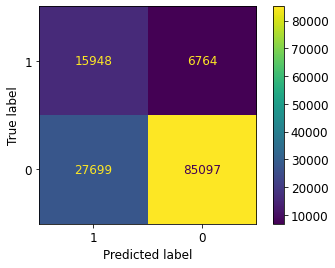

F1-score for the confusion matrix: 0.480658


In [26]:
##define model with optimal hyperparameters
lgbmc_best = lgb.LGBMClassifier(objective='binary',random_state=1,**lgbmc_best_hp)

print("Performance of LightGBM classifier with optimal hyperparamters")
print()

##evaluate model using k-fold cross validation
f1, precision, recall = eval_model_cv(lgbmc_best, 5, X_train, y_train)

##Fitting the model on training set
lgbmc_best.fit(X_train,y_train)
##Confusion Matrix for whole training set
print()
print('\n Confusion matrix for training data:')
conf_mat(lgbmc_best,X_train,y_train)

Next we find the best classification threshold for the trained LightGBM classifier (with optimal hyperparamters), i.e. threshold that gives maximum f1-score on the precision-recall curve.


 Best Threshold=0.547586, F-Score=0.484, Precision=0.391, Recall=0.635


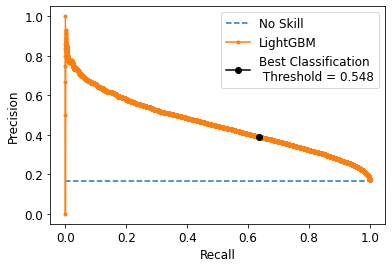


 Confusion matrix for training data:


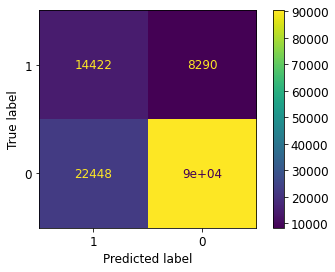

F1-score for the confusion matrix: 0.484106


In [27]:
##Finding the Optimal threshold value
threshold_lgbm, best_f1_lgbm, best_precison_lgbm, best_recall_lgbm = opt_threshold(lgbmc_best,'LightGBM', X_train, y_train)

Finally, we check the performance for the trained LightGBM classifier (with optimal hyperparamters) on the test set with best classification threshold (obtained in previous cell) used for class prediction.

In [28]:
##summarize performance of LightGBM on test set
eval_model_test(lgbmc_best,'LightGBM',X_test,y_test,threshold_lgbm)

Scores on the test set for LightGBM:
Precision: 0.391
Recall: 0.624
F1-score: 0.481


### CatBoost Classifier

CatBoost has in-built capabilities for working specifically with categorical features. Since 19 out of the 22 features in our dataset are categorical, we were interested in seeing how this model performs compared to other two boosting methods.

The learning objective used is **'Logloss'** which has the same log-loss (cost) function as logistic regression for binary classification.

First we need to set up the FeatureData required for CatBoost training (pool class). We also need to define a list of categorical features.

In [29]:
##List of categorical features
cat_features = list(train.columns.drop(['DIABETE3','_TOTINDA','_BMI5','PHYSHLTH','MENTHLTH']))
##converting categorical feature values to string type
cat_dtype = {cat: 'str' for cat in cat_features}
X_catb = train.drop(['DIABETE3','_TOTINDA'], axis = 1).astype(cat_dtype)
##Creating the pool class
pool_train = catboost.Pool(X_catb, train['DIABETE3'],cat_features)

To start with, we use the default paramter values (except n_estimators = 100) of CatBoostClassifier.

Performance of vanilla CatBoost

The scores for 5-fold cross validation are:
Mean F1-score: 0.264
Mean Precision: 0.549
Mean Recall: 0.174


 Confusion matrix for whole training data:


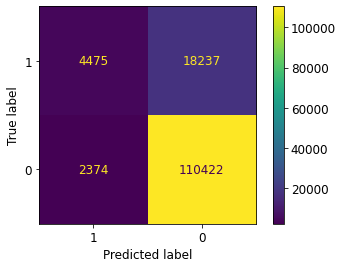

F1-score for the confusion matrix: 0.302764


In [30]:
##define model
clf_catb = catboost.CatBoostClassifier(n_estimators = 100,objective='Logloss',verbose=False,cat_features = cat_features)

print("Performance of vanilla CatBoost")
print()

##evaluate model using kfold cross validation
f1, precision, recall = eval_model_cv(clf_catb, 5, X_catb, y_train)

##Fitting the model on training set
clf_catb.fit(pool_train)
##Confusion Matrix for whole training set
print()
print('\n Confusion matrix for whole training data:')
conf_mat(clf_catb,X_catb,y_train)

Next, for handling class imbalance, asymmetry in the cost function is introduced through the hyperparameter $\textit{scale_pos_weight}$ which can be seen as the weight for positive class (i.e. diabetic in our case). \\

Here, we have taken $\textit{scale_pos_weight}= 6$ based on the heuristic used for XGBoost classifier before.

Performance of CatBoost with asymmetric loss function

The scores for 5-fold cross validation are:
Mean F1-score: 0.448
Mean Precision: 0.310
Mean Recall: 0.803


 Confusion matrix for whole training data:


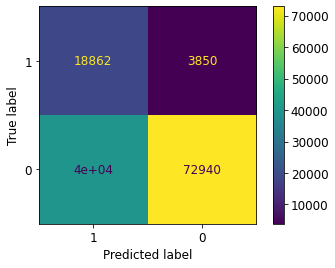

F1-score for the confusion matrix: 0.463269


In [31]:
##define model
clf_catb = catboost.CatBoostClassifier(n_estimators = 100,objective='Logloss',scale_pos_weight=6,cat_features = cat_features,verbose=False)

print("Performance of CatBoost with asymmetric loss function")
print()

##evaluate model using kfold cross validation
f1, precision, recall = eval_model_cv(clf_catb, 5, X_catb, y_train)

##Fitting the model on training set
clf_catb.fit(pool_train)
##Confusion Matrix for whole training set
print()
print('\n Confusion matrix for whole training data:')
conf_mat(clf_catb,X_catb,y_train)

We can see that adding asymmetry to loss function via scale_pos_weight gives much better performance than taking classes to be symmetric in loss function.

We can further tune the hyperparameters. For this, we will be using bayesian optimization based hyperopt python library. \\
**Note:** \\
**1) Run time for the following hyperparamter search is ~120 min. Consider using the optimal hyperparameter pre-defined in the next cell that has been found after running this hyperparmameter search.** \\
**2) Due to randomization in the hyperOpt based search, you might get different values for the hyperparamter if you run the hyperparameter search in the next cell. But the optimal mean F1-score (average over k-fold CV) from the search would still be around 0.478 for CatBoost.**

{'learning_rate': 0.46454618705778833, 'max_depth': 3, 'n_estimators': 261, 'reg_lambda': 3.1900367358015154, 'rsm': 0.5511029450634768, 'scale_pos_weight': 5.382449319723358, 'subsample': 0.5105804213776108}
new best:
0.4582248720927892
{'learning_rate': 0.3257848550801441, 'max_depth': 4, 'n_estimators': 454, 'reg_lambda': 1.953705592785437, 'rsm': 0.8130538525000726, 'scale_pos_weight': 5.1838396427888345, 'subsample': 0.5023824464003928}
new best:
0.46048050008730873
{'learning_rate': 0.15385457540106917, 'max_depth': 7, 'n_estimators': 383, 'reg_lambda': 3.842554247088996, 'rsm': 0.6576372853391592, 'scale_pos_weight': 5.046422058425404, 'subsample': 0.7403827468298854}
new best:
0.4620245006149716
{'learning_rate': 0.05366784653416321, 'max_depth': 7, 'n_estimators': 484, 'reg_lambda': 1.3978439370041464, 'rsm': 0.8013308182323811, 'scale_pos_weight': 3.7940894419891813, 'subsample': 0.9867016979178269}
new best:
0.4765388958419784
{'learning_rate': 0.31075249200702215, 'max_dept

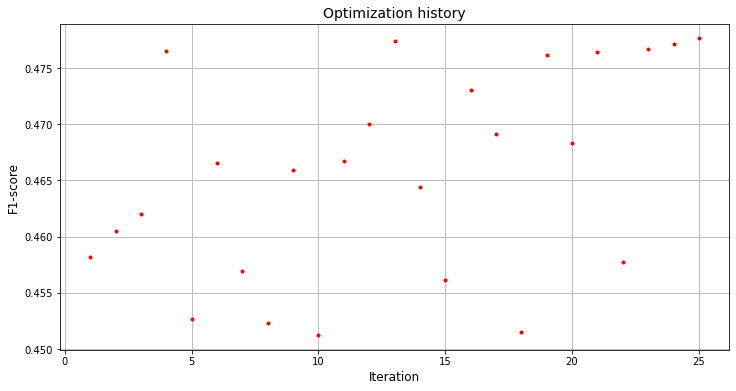

In [ ]:
# Code for using hyperopt for hysperparameter search to optimize F1 score taken from
# https://www.kaggle.com/rendyk/bayesian-optimization-bayes-opt-or-fmin#hyperopt
# https://districtdatalabs.silvrback.com/parameter-tuning-with-hyperopt

## Define the hyperparamterparamter space
catb_param_space = {'max_depth': hp.choice('depth', range(3,9)),
 'learning_rate': hp.uniform('learning_rate',0.05,0.5),
 'subsample': hp.uniform('subsample',0.5,1.0),
 'n_estimators': hp.choice('n_estimators', range(100,500)),
 'scale_pos_weight': hp.uniform('scale_pos_weight',3,6),
 'rsm': hp.uniform('rsm',0.5,1.0),
 'reg_lambda': hp.uniform('reg_lambda',1,4)}

best = 0
##The function to be optimized by hyperopt.fmin(), i.e. output of this function is mean f1-score (averaged over k-fold CV) 
##which is being optimized by hyprOpt.fmin().
def catb_func(params):
    global best
    print(params)

    ##Define CatBoostClassifier
    clf = catboost.CatBoostClassifier(objective='Logloss',random_state=1,cat_features = cat_features,**params,verbose=False)
    ##Compute the mean f1 score for kfold cross validation
    score = cross_val_score(clf, X_catb, y_train, scoring='f1', cv=5).mean()
    ##For keeping track of optimal f1-score, print the score everytime a better value is found
    if score > best:
        best = score
        print ('new best:', best)

    ##returning -ve of score because hyperopt.fmin() minimizes a function. So in our we are minimizing -ve of f1-score.
    return {'loss': -score, 'status': STATUS_OK}

##Start the timer for hyperparamter optimization
start = time.time()
##Max number of evluations for hyperopt.fmin()
max_iterations = 25
##Find the optimal hyperparamter set. Also storing the optimization history.
catb_param_space_indices, catb_trials = opt_hyperparameter(catb_param_space,catb_func,max_iterations)
##Obtain the hyperparamter values in the hyperparamter space defined by catb_param_space_indices
catb_best_hp = space_eval(catb_param_space,catb_param_space_indices)

print('It takes %s minutes' % ((time.time() - start)/60))
print('---------------Optimal Hyperparamter Set-------------------')
print(catb_best_hp)
print('---------------Optimization History-------------------')
optimization_history(catb_trials)

The cell below has the optimal hyperparameters found for CatBoost classifier after running the search in previous cell. **Please uncomment if you want to use this hyperparameter set instead of running the hyperOpt based search.** \\
**Note: Due to randomization in the hyperOpt based search, you might get different values for the optimal hyperparamter if you ran the hyperparameter search in previous cell. But the optimal mean F1-score (average over k-fold CV) from the search would still be around 0.478 for CatBoost classifier.** 

In [32]:
#catb_best_hp={'learning_rate': 0.11900217510409172, 'max_depth': 4, 'n_estimators': 170, 'reg_lambda': 3.247685409842723, 'rsm': 0.9373524470777777, 'scale_pos_weight': 3.3409730512826683, 'subsample': 0.5588187034204282}

Assessing the performance of the catboost classifier with optimal hyperparamters based on 5-fold CV and on the whole training set. \\
We find that the performance improves with hyperparameter tuning.

Performance of CatBoost classifier with optimal hyperparamters

The scores for 5-fold cross validation are:
Mean F1-score: 0.478
Mean Precision: 0.381
Mean Recall: 0.641


 Confusion matrix for training data:


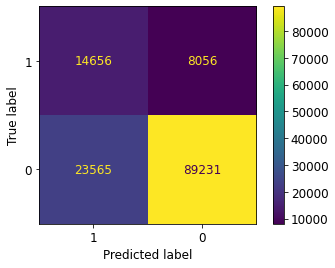

F1-score for the confusion matrix: 0.481053


In [34]:
##define model with optimal hyperparameters
catbc_best = catboost.CatBoostClassifier(objective='Logloss',random_state=1,cat_features = cat_features,**catb_best_hp,verbose=False)

print("Performance of CatBoost classifier with optimal hyperparamters")
print()

##evaluate model using k-fold cross validation
f1, precision, recall = eval_model_cv(catbc_best, 5, X_catb, y_train)

##Fitting the model on training st
catbc_best.fit(pool_train)
##Confusion Matrix for whole training set
print()
print('\n Confusion matrix for training data:')
conf_mat(catbc_best,X_catb,y_train)

Next we find the best classification threshold for the trained CatBoost classifier (with optimal hyperparamters), i.e. threshold that gives maximum f1-score on the precision-recall curve.


 Best Threshold=0.514922, F-Score=0.482, Precision=0.392, Recall=0.625


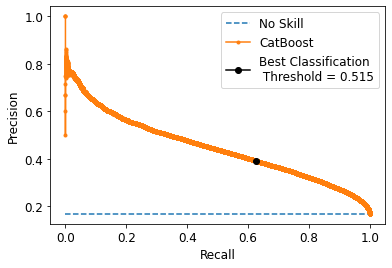


 Confusion matrix for training data:


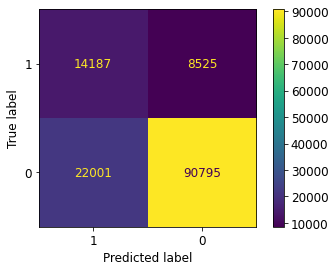

F1-score for the confusion matrix: 0.481732


In [35]:
##Finding the Optimal threshold value
threshold_catb, best_f1_catb, best_precison_catb, best_recall_catb = opt_threshold(catbc_best,'CatBoost', X_catb, y_train)

Finally, we check the performance for the trained CatBoost classifier (with optimal hyperparamters) on the test set with best classification threshold (obtained in previous cell) used for class prediction.

In [36]:
##summarize performance of CatBoost on test set
eval_model_test(catbc_best,'CatBoost',test.drop(['DIABETE3','_TOTINDA'], axis = 1).astype(cat_dtype),y_test,threshold_catb)

Scores on the test set for CatBoost:
Precision: 0.391
Recall: 0.613
F1-score: 0.478


## Undersampled Training Set for handling class imbalance

We also explored the strategy of using undersampled training set for tackling class imbalance. For this we trained random forest and LightGBM models using undersampled train set. **However, undersampling did not did not give better performance than the combination of asymmetric cost and optimal threshold on the test set.**

We followed the similar to the pipeline for analysis as before but now with undersampled train set having equal proportion of both classes instead of whole imbalanced training set. \\
1) Try the model with default parameters. \\
2) Find optimal hyperparameters based on 5-fold cross validation using HyperOpt

In [38]:
##Reading the undersampled training set
train_under = pd.read_csv(data_path + 'Train_undersample.csv')
##Defining the X (feature values) and y (target variable) for training
X_train_under = train_under.drop(['DIABETE3','_TOTINDA'], axis = 1).values
y_train_under = train_under['DIABETE3'].values.astype('int64')

### Random Forest

To start with, we use the default paramter values (except max_depth = 4) of RandomForestClasifier. 

Performance of vanilla random forest for Under-sampled Training set

The scores for 5-fold cross validation are:
Mean F1-score: 0.723
Mean Precision: 0.696
Mean Recall: 0.753


 Confusion matrix for undersampled training data:


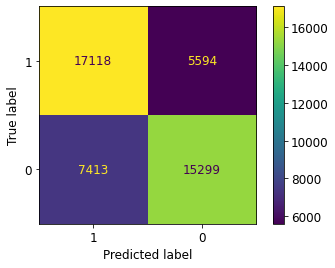

F1-score for the confusion matrix: 0.724679


In [39]:
##define model
clf_rf = RandomForestClassifier(max_depth=4,random_state=1)

print("Performance of vanilla random forest for Under-sampled Training set")
print()

##evaluate model using kfold cross validation
f1, precision, recall = eval_model_cv(clf_rf, 5, X_train_under, y_train_under)

##Fitting the model on undersampled training set
clf_rf.fit(X_train_under,y_train_under)
##Confusion Matrix for undersampled training set
print()
print('\n Confusion matrix for undersampled training data:')
conf_mat(clf_rf,X_train_under,y_train_under)

We can further tune the hyperparameters. For this, we will be using bayesian optimization based hyperopt python library. \\
**Note:** \\
**1) Run time for the following hyperparamter search is ~13 min. Consider using the optimal hyperparameter pre-defined in the next cell that has been found after running this hyperparmameter search.** \\
**2) Due to randomization in the hyperOpt based search, you might get different values for the hyperparamter if you run the hyperparameter search in the next cell. But the optimal mean F1-score (average over k-fold CV) from the search would still be around 0.736 for Random Forest on undersampled training set.**

{'max_depth': 2, 'max_features': 'sqrt', 'min_samples_split': 6, 'n_estimators': 362}
New best F1-score: 0.711891
{'max_depth': 2, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 270}
New best F1-score: 0.712343
{'max_depth': 8, 'max_features': 'log2', 'min_samples_split': 3, 'n_estimators': 396}
New best F1-score: 0.736101
{'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 4, 'n_estimators': 270}
{'max_depth': 2, 'max_features': 'sqrt', 'min_samples_split': 3, 'n_estimators': 347}
{'max_depth': 8, 'max_features': 'sqrt', 'min_samples_split': 6, 'n_estimators': 391}
{'max_depth': 8, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 499}
{'max_depth': 4, 'max_features': 'sqrt', 'min_samples_split': 4, 'n_estimators': 283}
{'max_depth': 8, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 164}
{'max_depth': 4, 'max_features': 'sqrt', 'min_samples_split': 3, 'n_estimators': 450}
{'max_depth': 7, 'max_features': 'log2', 'min_samples_sp

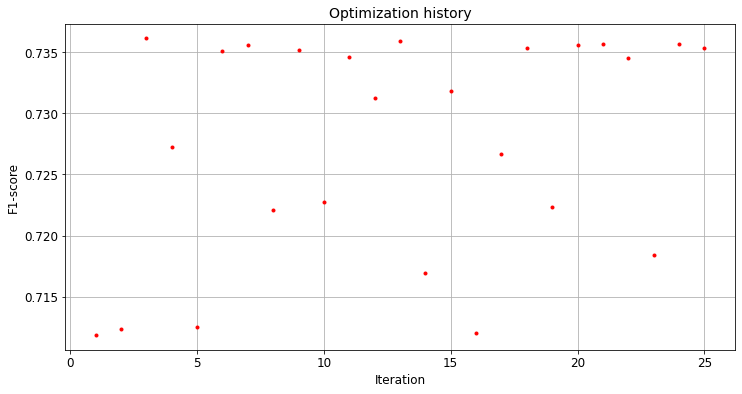

In [ ]:
##Code for using hyperopt for hysperparameter search to optiiza F1 score taken from
##https://www.kaggle.com/rendyk/bayesian-optimization-bayes-opt-or-fmin#hyperopt
##https://districtdatalabs.silvrback.com/parameter-tuning-with-hyperopt

##Define the hyperparamter space
rf_param_space_under = {'max_depth': hp.choice('max_depth', range(2,9)),
 'max_features': hp.choice('max_features', ['sqrt','log2']),
 'min_samples_split': hp.choice('min_samples_split',range(2,8)),
 'n_estimators': hp.choice('n_estimators', range(100,500))}

best = 0  
##The function to be optimized by hyperopt.fmin(), i.e. output of this function is mean f1-score (averaged over k-fold CV) 
##which is being optimized by hyprOpt.fmin().
def rfc_func(params):
    global best
    print(params)

    ##Define the random forest classifier
    clf = RandomForestClassifier(random_state=1,**params)
    ##Compute the mean f1 score for kfold cross validation
    score = cross_val_score(clf, X_train_under, y_train_under, scoring='f1', cv=5).mean()
    ##For keeping track of optimal f1-score, print the score everytime a better value is found
    if score > best:
        best = score
        print ('New best F1-score: %f' % best)

    ##returning -ve of score because hyperopt.fmin() minimizes a function. So in our case, we are minimizing -ve of f1-score.
    return {'loss': -score, 'status': STATUS_OK}  

##Start the timer for hyperparamter optimization
start = time.time()
##Max number of evaluations for hyperopt.fmin()
max_iterations = 25
##Find the optimal hyperparamter set. Also storing the optimization history.
rf_param_space_indices_under, rf_trials_under = opt_hyperparameter(rf_param_space_under,rfc_func,max_iterations)
##Obtain the hyperparamter values in the hyperparamter space defined by rf_param_space_indices
rf_best_hp_under = space_eval(rf_param_space_under,rf_param_space_indices_under)

print('It takes %s minutes' % ((time.time() - start)/60))
print('---------------Optimal Hyperparamter Set-------------------')
print(rf_best_hp_under)
print('---------------Optimization History-------------------')
optimization_history(rf_trials_under)

The cell below has the optimal hyperparameters found for random forest after running the search in previous cell. **Please uncomment if you want to use this hyperparameter set instead of running the hyperOpt based search.** \\
**Note: Due to randomization in the hyperOpt based search, you might get different values for the optimal hyperparamter if you ran the hyperparameter search in previous cell. But the optimal mean F1-score (average over k-fold CV) from the search would still be around 0.736 for random forest on undersampled training set.** 

In [40]:
#rf_best_hp_under={'max_depth': 8, 'max_features': 'log2', 'min_samples_split': 3, 'n_estimators': 396}

Assessing the performance of the random forest classifier with optimal hyperparamters based on 5-fold CV and on the undersampled training set. 

Performance of LightGBM classifier with optimal hyperparamters for Under-sampled Training set

The scores for 5-fold cross validation are:
Mean F1-score: 0.736
Mean Precision: 0.707
Mean Recall: 0.768


 Confusion matrix for training data:


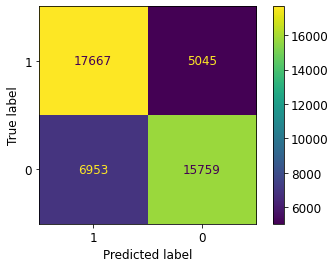

F1-score for the confusion matrix: 0.746514


In [41]:
##define model with optimal hyperparameters
rfc_best_under = RandomForestClassifier(random_state=1,**rf_best_hp_under)

print("Performance of LightGBM classifier with optimal hyperparamters for Under-sampled Training set")
print()

##evaluate model using k-fold cross validation
f1, precision, recall = eval_model_cv(rfc_best_under, 5, X_train_under, y_train_under)

##Fitting the model on undersampled training set
rfc_best_under.fit(X_train_under,y_train_under)
##Confusion Matrix for undersampled training set
print()
print('\n Confusion matrix for training data:')
conf_mat(rfc_best_under,X_train_under,y_train_under)

Finally, we check the performance for the Random Forest classifier (trained on undersampled train set with optimal hyperparamters) on the test set.

In [42]:
##summarize performance of random forest (trained on undersampled train set) on test set
eval_model_test(rfc_best_under,'Random Forest',X_test,y_test)

Scores on the test set for Random Forest:
Precision: 0.326
Recall: 0.763
F1-score: 0.457


### LightGBM

The learning objective used is **'binary'** which has the same log-loss (cost) function as logistic regression for binary classification.

To start with, we use the default paramter values (except max_depth = 3 and num_leaves = 5) of LGBMClassifier.

Performance of vanilla LightGBM for Under-sampled Training set

The scores for 5-fold cross validation are:
Mean F1-score: 0.735
Mean Precision: 0.714
Mean Recall: 0.757


 Confusion matrix for undersampled training data:


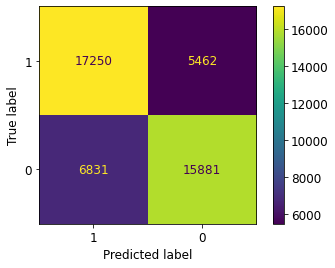

F1-score for the confusion matrix: 0.737290


In [44]:
##define model
clf_lgbm = lgb.LGBMClassifier(objective='binary',max_depth=3,num_leaves=5)

print("Performance of vanilla LightGBM for Under-sampled Training set")
print()

##evaluate model using kfold cross validation
f1, precision, recall = eval_model_cv(clf_lgbm, 5, X_train_under, y_train_under)

##Fitting the model on undersampled training set
clf_lgbm.fit(X_train_under,y_train_under)
##Confusion Matrix for undersampled training set
print()
print('\n Confusion matrix for undersampled training data:')
conf_mat(clf_lgbm,X_train_under,y_train_under)

We can further tune the hyperparameters. For this, we will be using bayesian optimization based hyperopt python library. \\
**Note:** \\
**1) Run time for the following hyperparamter search is ~2 min. Consider using the optimal hyperparameter pre-defined in the next cell that has been found after running this hyperparmameter search.** \\
**2) Due to randomization in the hyperOpt based search, you might get different values for the hyperparamter if you run the hyperparameter search in the next cell. But the optimal mean F1-score (average over k-fold CV) from the search would still be around 0.737 for LightGBM on undersampled training set.**

{'colsample_bytree': 0.9910932301210764, 'learning_rate': 0.4962120968084512, 'max_depth': 6, 'min_split_gain': 0.025286488795407337, 'n_estimators': 388, 'reg_lambda': 3.459360776813612, 'subsample': 0.8737132546208446}
new best:
0.7249498757080858
{'colsample_bytree': 0.707978043523225, 'learning_rate': 0.1596383947920846, 'max_depth': 7, 'min_split_gain': 0.1843069010093029, 'n_estimators': 320, 'reg_lambda': 2.2801234427735757, 'subsample': 0.6926956220157083}
new best:
0.7357853964344266
{'colsample_bytree': 0.996083686259968, 'learning_rate': 0.33874763998480484, 'max_depth': 4, 'min_split_gain': 0.2942423119062391, 'n_estimators': 233, 'reg_lambda': 1.7153363781585145, 'subsample': 0.5088537422565265}
new best:
0.7360668840436493
{'colsample_bytree': 0.8967917697028827, 'learning_rate': 0.07311347126559724, 'max_depth': 3, 'min_split_gain': 0.15404388652245313, 'n_estimators': 199, 'reg_lambda': 3.6169416063638815, 'subsample': 0.5035038658172932}
{'colsample_bytree': 0.98361477

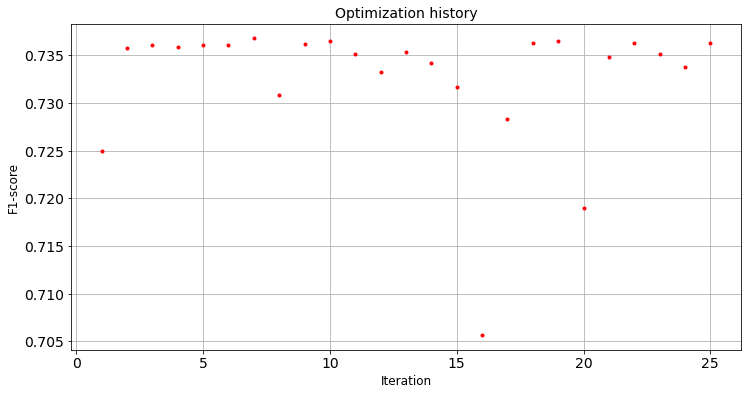

In [ ]:
##Code for using hyperopt for hysperparameter search to optimize F1 score taken from
##https://www.kaggle.com/rendyk/bayesian-optimization-bayes-opt-or-fmin#hyperopt
##https://districtdatalabs.silvrback.com/parameter-tuning-with-hyperopt

##Define the hyperparamterparamter space
lgbmc_param_space_under = {'max_depth': hp.choice('max_depth', range(3,9)),
 'learning_rate': hp.uniform('learning_rate',0.05,0.5),
 'subsample': hp.uniform('subsample',0.5,1.0),
 'n_estimators': hp.choice('n_estimators', range(100,500)),
 'min_split_gain': hp.uniform('min_split_gain',0,0.3),
 'colsample_bytree': hp.uniform('colsample_bytree',0.5,1.0),
 'reg_lambda': hp.uniform('reg_lambda',1,4)}

best = 0
##The function to be optimized by hyperopt.fmin(), i.e. output of this function is mean f1-score (averaged over k-fold CV) 
##which is being optimized by hyprOpt.fmin().
def lgbmc_func(params):
    global best
    print(params)

    ##Define LightGBM classifier
    clf = lgb.LGBMClassifier(objective='binary',random_state=1,num_leaves = round(np.power(2,params['max_depth'])*0.6),**params)
    ##Compute the mean f1 score for kfold cross validation
    score = cross_val_score(clf, X_train_under, y_train_under, scoring='f1', cv=5).mean()
    ##For keeping track of optimal f1-score, print the score everytime a better value is found
    if score > best:
        best = score
        print ('new best:', best)

    ##returning -ve of score because hyperopt.fmin() minimizes a function. So in our we are minimizing -ve of f1-score.
    return {'loss': -score, 'status': STATUS_OK}

##Start the timer for hyperparamter optimization
start = time.time()
##Max number of evaluations for hyperopt.fmin()
max_iterations = 25
##Find the optimal hyperparamter set. Also storing the optimization history.
lgbmc_param_space_indices_under, lgbmc_trials_under = opt_hyperparameter(lgbmc_param_space_under,lgbmc_func,max_iterations)
##Obtain the hyperparamter values in the hyperparamter space defined by lgbmc_param_space_indices
lgbmc_best_hp_under = space_eval(lgbmc_param_space_under,lgbmc_param_space_indices_under)

print('It takes %s minutes' % ((time.time() - start)/60))
print('---------------Optimal Hyperparamter Set-------------------')
print(lgbmc_best_hp_under)
print('---------------Optimization History-------------------')
optimization_history(lgbmc_trials_under)

The cell below has the optimal hyperparameters found for LightGBM classifier after running the search in previous cell. **Please uncomment if you want to use this hyperparameter set instead of running the hyperOpt based search.** \\
**Note: Due to randomization in the hyperOpt based search, you might get different values for the optimal hyperparamter if you ran the hyperparameter search in previous cell. But the optimal mean F1-score (average over k-fold CV) from the search would still be around 0.737 for LightGBM on undersampled training set.** 

In [45]:
#lgbmc_best_hp_under={'colsample_bytree': 0.602837023242682, 'learning_rate': 0.32370343045804756, 'max_depth': 4, 'min_split_gain': 0.2865973687995796, 'n_estimators': 134, 'reg_lambda': 1.8748826878862423, 'subsample': 0.5787113991537967}

Assessing the performance of the lightGBM classifier with optimal hyperparamters based on 5-fold CV and on the undersampled training set. 

Performance of LightGBM classifier with optimal hyperparamters for Under-sampled Training set

The scores for 5-fold cross validation are:
Mean F1-score: 0.736
Mean Precision: 0.711
Mean Recall: 0.762


 Confusion matrix for training data:


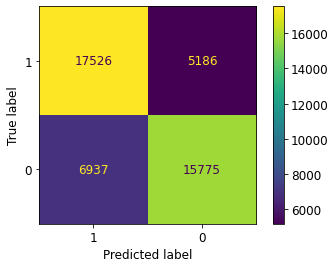

F1-score for the confusion matrix: 0.743021


In [46]:
##define model with optimal hyperparameters
lgbmc_best_under = lgb.LGBMClassifier(objective='binary',random_state=1,**lgbmc_best_hp_under)

print("Performance of LightGBM classifier with optimal hyperparamters for Under-sampled Training set")
print()

##evaluate model using k-fold cross validation
f1, precision, recall = eval_model_cv(lgbmc_best_under, 5, X_train_under, y_train_under)

##Fitting the model on undersampled training set
lgbmc_best_under.fit(X_train_under,y_train_under)
##Confusion Matrix for undersampled training set
print()
print('\n Confusion matrix for training data:')
conf_mat(lgbmc_best_under,X_train_under,y_train_under)

Finally, we check the performance for the LightGBM classifier (trained on undersampled train set with optimal hyperparamters) on the test set.

In [47]:
##summarize performance of LightGBM(trained on undersampled train set) on test set
eval_model_test(lgbmc_best_under,'LightGBM',X_test,y_test)

Scores on the test set for LightGBM:
Precision: 0.332
Recall: 0.761
F1-score: 0.463
